In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
import nengo
from nengo.solvers import LstsqL2

In [2]:
# Create a subclass of the "network". 
# PAY SUPER ATTENTION to the INDENTATION!!!!
class InputSignal(nengo.Network):
           def __init__(self):
               self.stim = nengo.Node(lambda t: (signal.square(2*np.pi*0.5*t)+1)/2 + np.random.randn(1)/50*(signal.square(2*np.pi*0.5*t)+1)/2)

In [3]:
# Create a second subclass of the "network".
class VoidSignal(nengo.Network):
           def __init__(self):
               self.stim = nengo.Node(lambda t: [0])

In [4]:
def pre_pair():
    ## unpaired - CS is presented to show that there is no fear response to the stimulus
    with nengo.Network() as submodel:
        submodel.cs = InputSignal()
        submodel.us = VoidSignal()
        
        submodel.ensemble_c = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_u = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_la = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_bl = nengo.Ensemble(n_neurons=80, dimensions=1)
        submodel.ensemble_cem = nengo.Ensemble(n_neurons=60, dimensions=1)
        submodel.ensemble_fear = nengo.Ensemble(n_neurons=60, dimensions=1)
        
        nengo.Connection(submodel.cs.stim, submodel.ensemble_c)
        nengo.Connection(submodel.us.stim, submodel.ensemble_u)
        nengo.Connection(submodel.ensemble_c, submodel.ensemble_la, function=lambda x: np.random.randn(1)/100)
        nengo.Connection(submodel.ensemble_u, submodel.ensemble_la, synapse=.01, transform=1)
        nengo.Connection(submodel.ensemble_la, submodel.ensemble_bl, synapse=.01, transform=0.965)
        nengo.Connection(submodel.ensemble_la, submodel.ensemble_cem, synapse=.01, transform=.035)
        nengo.Connection(submodel.ensemble_bl, submodel.ensemble_cem, synapse=.01)
        
        # Fear is not a group of neurons; instead it corresponds to output of CEm.
        nengo.Connection(submodel.ensemble_cem, submodel.ensemble_fear, function=lambda x: x if x > 0.75 else 0)
        
    return submodel

In [5]:
def pairing():
    ## pairing - CS is paired with the US    
    with nengo.Network() as submodel:
        
        submodel.cs = InputSignal()
        submodel.us = InputSignal()
        
        submodel.ensemble_c = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_u = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_la = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_bl = nengo.Ensemble(n_neurons=80, dimensions=1)
        submodel.ensemble_cem = nengo.Ensemble(n_neurons=60, dimensions=1)
        submodel.ensemble_fear = nengo.Ensemble(n_neurons=60, dimensions=1)

        nengo.Connection(submodel.cs.stim, submodel.ensemble_c)
        nengo.Connection(submodel.us.stim, submodel.ensemble_u)
        nengo.Connection(submodel.ensemble_c, submodel.ensemble_la, learning_rule_type=nengo.PES(learning_rate=2e-4))
        nengo.Connection(submodel.ensemble_u, submodel.ensemble_la, synapse=.01, transform=1)
        nengo.Connection(submodel.ensemble_la, submodel.ensemble_bl, transform=.965)
        nengo.Connection(submodel.ensemble_la, submodel.ensemble_cem, synapse=.01, transform=.035)
        nengo.Connection(submodel.ensemble_bl, submodel.ensemble_cem, synapse=.01)
        
        # Fear is not a group of neurons; instead it corresponds to output of CEm.
        nengo.Connection(submodel.ensemble_cem, submodel.ensemble_fear, function=lambda x: x if x > 0.75 else 0)
        
    return submodel

In [6]:
def post_pair():
    ## CS is presented in the absence of the US
    with nengo.Network() as submodel:
        submodel.cs = InputSignal()
        submodel.us = VoidSignal()
        
        submodel.ensemble_c = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_u = nengo.Ensemble(n_neurons=100, dimensions=1)        
        submodel.ensemble_la = nengo.Ensemble(n_neurons=100, dimensions=1)
        submodel.ensemble_bl = nengo.Ensemble(n_neurons=80, dimensions=1)
        submodel.ensemble_cem = nengo.Ensemble(n_neurons=60, dimensions=1)
        submodel.ensemble_fear = nengo.Ensemble(n_neurons=60, dimensions=1)

        nengo.Connection(submodel.cs.stim, submodel.ensemble_c)
        nengo.Connection(submodel.us.stim, submodel.ensemble_u)        
        nengo.Connection(submodel.ensemble_c, submodel.ensemble_la, synapse=.01, transform=1)
        nengo.Connection(submodel.ensemble_u, submodel.ensemble_la, synapse=.01, transform=1)
        nengo.Connection(submodel.ensemble_la, submodel.ensemble_bl, transform=.965)
        nengo.Connection(submodel.ensemble_la, submodel.ensemble_cem, synapse=.01, transform=.035)
        nengo.Connection(submodel.ensemble_bl, submodel.ensemble_cem, synapse=.01)
        
        # Fear is not a group of neurons; instead it corresponds to output of CEm.
        nengo.Connection(submodel.ensemble_cem, submodel.ensemble_fear, function=lambda x: x if x > 0.75 else 0)
        
    return submodel

In [7]:
def testf(argu):
    with nengo.Simulator(argu) as sim:
        sim.run(12.0)
    #t = sim.trange()
    return sim

In [8]:
model = nengo.Network()
with model:
    
    # without learning; CS isn't paired with US
    model.pre_paired = pre_pair()
    
    # Probing an ensemble gives the decoded value
    CS_p_pre = nengo.Probe(model.pre_paired.cs.stim)
    US_p_pre = nengo.Probe(model.pre_paired.us.stim)
    CEm_p_pre = nengo.Probe(model.pre_paired.ensemble_cem, synapse=.01)
    Fear_p_pre = nengo.Probe(model.pre_paired.ensemble_fear, synapse=.08)
    
    # CS is paired with US
    model.s_pairing = pairing()
    
    # Probing an ensemble gives the decoded value
    CS_p_p = nengo.Probe(model.s_pairing.cs.stim)
    US_p_p = nengo.Probe(model.s_pairing.us.stim)
    CEm_p_p = nengo.Probe(model.s_pairing.ensemble_cem, synapse=.01)
    Fear_p_p = nengo.Probe(model.s_pairing.ensemble_fear, synapse=.01)
    
    # CS is presented in the absence of the US
    model.post_paired = post_pair()
    
    # Probing an ensemble gives the decoded value
    CS_p_pst = nengo.Probe(model.post_paired.cs.stim)
    US_p_pst = nengo.Probe(model.post_paired.us.stim)
    CEm_p_pst = nengo.Probe(model.post_paired.ensemble_cem, synapse=.01)
    Fear_p_pst = nengo.Probe(model.post_paired.ensemble_fear, synapse=.01)

In [9]:
simulation = testf(model)

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

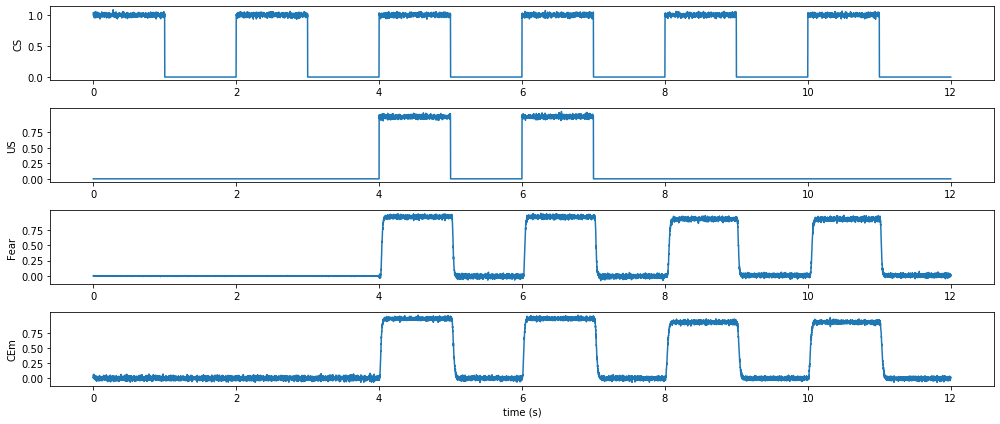

In [10]:
CS_p = np.zeros(12000)
US_p = np.zeros(12000)
CEm_p = np.zeros(12000)
Fear_p = np.zeros(12000)
for i in range(0,4000):
    CS_p[i] = simulation.data[CS_p_pre][i]
    US_p[i] = simulation.data[US_p_pre][i]
    CEm_p[i] = simulation.data[CEm_p_pre][i]
    Fear_p[i] = simulation.data[Fear_p_pre][i]
for i in range(4000,7999):
    CS_p[i] = simulation.data[CS_p_p][i]
    US_p[i] = simulation.data[US_p_p][i]
    CEm_p[i] = simulation.data[CEm_p_p][i]
    Fear_p[i] = simulation.data[Fear_p_p][i]
for i in range(8000,11999):
    CS_p[i] = simulation.data[CS_p_pst][i]
    US_p[i] = simulation.data[US_p_pst][i]
    CEm_p[i] = simulation.data[CEm_p_pst][i]
    Fear_p[i] = simulation.data[Fear_p_pst][i]
    
t = simulation.trange()
plt.figure(figsize=(14, 6))
plt.subplot(4, 1, 1)

plt.plot(t, CS_p)
plt.ylabel("CS")
    
plt.subplot(4, 1, 2)
plt.plot(t, US_p)
plt.ylabel("US")
plt.yticks(np.arange(0, 1, step=0.25))
    
plt.subplot(4, 1, 3)
plt.plot(t, Fear_p)
plt.ylabel("Fear")
plt.yticks(np.arange(0, 1, step=0.25))

plt.subplot(4, 1, 4)
plt.plot(t, CEm_p)
plt.xlabel("time (s)")
plt.ylabel("CEm")
plt.yticks(np.arange(0, 1, step=0.25))
plt.tight_layout()